In [6]:
import os
os.chdir(r"C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel")
os.getcwd()


'C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel'

In [7]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# ============================================================
# ✅ FIX PATH FOR NOTEBOOK INSIDE /notebooks
# ============================================================
import sys, os
from pathlib import Path

# Xác định thư mục cha của notebooks/
project_root = Path(os.getcwd()).parent  # => C:\Users\User\RR_model
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # ⚠️ thêm project_root, KHÔNG thêm src

print("📁 Project root added:", project_root)

# Kiểm tra lại
import importlib.util
print("🔍 src module found:", importlib.util.find_spec("src"))
import os
os.getcwd()


📁 Project root added: C:\Users\MAFC4709\Python_work
🔍 src module found: ModuleSpec(name='src', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000025235543E20>, origin='C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel\\src\\__init__.py', submodule_search_locations=['C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel\\src'])


'C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel'

In [9]:
# ===========================================================
# 📘 Roll Rate Demo v7 - Sử dụng dữ liệu thật từ Oracle hoặc SQL file
# ===========================================================

from pathlib import Path
import sys
import pandas as pd
import numpy as np

# --- 1️⃣ Setup đường dẫn và import các module ---
root = Path(".").resolve()
sys.path.append(str(root / "src"))

from src.data_loader import load_data
from src.config import CFG, OUT_ROOT
from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob

from src.rollrate.export_excel import export_transition_excel
from src.rollrate.backtest import (
    compute_actual_matrix,
    rollforward_validation,
    plot_matrix_diff,
    plot_distribution_compare
)

print("✅ Import modules thành công.")
print("Cấu hình CFG:", CFG)


# --- 2️⃣ Load dữ liệu thực tế ---
#sql_path = r"C:/Users/MAFC4709/Python_work/RR_model/sql/uns2.sql"

#df = load_data(sql_path)
df = load_data()
df['DISBURSAL_DATE'] = df['DISBURSAL_DATE'].apply(lambda x: x.replace(day=1))

#print(f"📦 Đã load {len(df):,} dòng dữ liệu từ {sql_path}")

# Kiểm tra các cột quan trọng
required_cols = [CFG["loan"], CFG["mob"], CFG["state"], CFG["ead"], CFG["cutoff"]]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ Thiếu các cột cần thiết trong data: {missing}")

print("✅ Dữ liệu có đủ các cột cần thiết:", required_cols)

# Nếu chưa có PRODUCT_TYPE thì thêm mặc định
if "PRODUCT_TYPE" not in df.columns:
    df["PRODUCT_TYPE"] = "A"
    print("⚠️ Không có PRODUCT_TYPE trong data, gán mặc định = 'A'")

# Convert cutoff về datetime
df[CFG["cutoff"]] = pd.to_datetime(df[CFG["cutoff"]])





✅ Import modules thành công.
Cấu hình CFG: {'loan': 'AGREEMENT_ID', 'mob': 'MOB', 'state': 'STATE_MODEL', 'orig_date': 'DISBURSAL_DATE', 'ead': 'PRINCIPLE_OUTSTANDING', 'disb': 'DISBURSAL_AMOUNT', 'cutoff': 'CUTOFF_DATE'}
📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\data\parquet
✅ Loaded 18,219,537 rows via pyarrow.dataset from C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\data\parquet
✅ Dữ liệu có đủ các cột cần thiết: ['AGREEMENT_ID', 'MOB', 'STATE_MODEL', 'PRINCIPLE_OUTSTANDING', 'CUTOFF_DATE']


## Nặng quá, chạy cho CDL trước

In [10]:
# Lọc trực tiếp, bỏ hết products khác
df = df[df["PRODUCT_TYPE"] == "CDLPIL"].reset_index(drop=True)


print("rows after filter:", len(df))



rows after filter: 18219537


In [11]:
import gc
gc.collect()


0

# 0. Import & config chung

In [12]:
import pandas as pd
import numpy as np

from src.config import (
    CFG,
    BUCKETS_CANON,
    BUCKETS_30P,
    BUCKETS_60P,
    BUCKETS_90P,
)

from src.rollrate.transition import compute_transition_by_mob
from src.rollrate.lifecycle import (
    build_full_lifecycle_amount,
    tag_forecast_rows_amount,
    add_del_metrics,
    aggregate_to_product,
    aggregate_products_to_portfolio,
    export_lifecycle_all_products_one_file,
)

from src.rollrate.forecast_full_history import forecast_full_history
from src.rollrate.del_metrics_simple import add_del_metrics_simple

from src.rollrate.calibration import (
    compute_k_per_product_ifrs_fullhistory,
    apply_k_to_lifecycle,
    apply_k_to_sale_plan,
)

from src.rollrate.seasonality import (
    build_seasonality,
    apply_seasonality_to_lifecycle,
    apply_seasonality_to_sale_plan,
)




# 1. Đọc data loan-level & chuẩn hoá

In [13]:
df_raw = df

In [14]:
# 1.1. Load data loan level


# 1.2. (Tuỳ) Chuẩn hoá tên cột, kiểu dữ liệu nếu cần
df_raw["PRODUCT_TYPE"] = df_raw["PRODUCT_TYPE"].astype(str)
df_raw["RISK_SCORE"]   = df_raw["RISK_SCORE"].astype(str)
df_raw[CFG["orig_date"]] = pd.to_datetime(df_raw[CFG["orig_date"]])


# 2. Build transition matrices theo MOB

In [15]:
matrices_by_mob, parent_fallback = compute_transition_by_mob(df_raw)

# (Tuỳ) validate matrices:
# from src.rollrate.forecast import validate_matrices
# validate_matrices(matrices_by_mob)


⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=500-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=550-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=600-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650+)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=OTHERS)
⚠️ Có 6 hàng có tổng weight = 0: ['DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 5 hàng có tổng weight = 0: ['DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 4 hàng có tổng weight = 0: ['DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 3 hàng có tổng weight = 0: ['PREPAY', 'WRITEOFF', 'SO

# 3. Lifecycle cho các khoản đã giải ngân (actual + forecast “gốc”)

In [16]:
max_mob = 36  # hoặc 48, 60 tuỳ ý

# 3.1. Build lifecycle EAD theo state
df_lifecycle = build_full_lifecycle_amount(
    df_raw=df_raw,
    matrices_by_mob=matrices_by_mob,
    max_mob=max_mob,
)

# 3.2. Tag actual vs forecast
df_lifecycle = tag_forecast_rows_amount(df_lifecycle, df_raw)

# 3.3. Tính DEL30/60/90 AMT & PCT (dùng DISB từ raw)
df_lifecycle = add_del_metrics(df_lifecycle, df_raw)


KeyError: "['DPD120+', 'DPD180+'] not in index"

# 4. Full-history forecast từ MOB0 (để backtest & tính k)

In [ ]:
# 4.1. Forecast full-history từ MOB0 → max_mob cho mọi vintage
df_fc_hist = forecast_full_history(
    df_raw=df_raw,
    matrices_by_mob=matrices_by_mob,
    max_mob=max_mob,
)

# 4.2. Tính DEL metrics đơn giản trên EAD (DISB_TOTAL lấy từ MOB0)
df_fc_hist = add_del_metrics_simple(df_fc_hist)
df_fc_hist["IS_FORECAST"] = 1


# 5. Chuẩn bị actual cho calibration & tính k per product (IFRS full-history)

In [ ]:
# 5.1. Lấy actual cho calibration (chỉ IS_FORECAST=0)
df_actual_for_calib = df_lifecycle[df_lifecycle["IS_FORECAST"] == 0].copy()

# 5.2. Cast key về cùng kiểu để merge cho chắc
for df_ in [df_actual_for_calib, df_fc_hist]:
    df_["PRODUCT_TYPE"] = df_["PRODUCT_TYPE"].astype(str)
    df_["RISK_SCORE"]   = df_["RISK_SCORE"].astype(str)
    df_["VINTAGE_DATE"] = pd.to_datetime(df_["VINTAGE_DATE"])

# 5.3. Tính k per product
H_MAP_CALIB = {
    "CDLPIL": 12,
    "TWLPIL": 12,
    "SPLPIL": 12,
    "SALPIL": 24,
    "TOPUP":  24,
    "XSELL":  24,
}
# compute_k_per_product_ifrs_fullhistory bên trong sẽ dùng H_MAP_CALIB, min_obs, trimmed_mean/median, clip…

k_dict = compute_k_per_product_ifrs_fullhistory(
    df_actual=df_actual_for_calib,
    df_forecast=df_fc_hist,
    H_map=H_MAP_CALIB,
    min_obs=5,
    method="trimmed_mean",
    clip_min=0.5,
    clip_max=1.5,
)

print("k per product:", k_dict)


# 6. Áp k + blending vào lifecycle lịch sử

In [ ]:
from src.rollrate.calibration import M_APPLY_MAP, DEFAULT_M_APPLY

# 6.1. Áp k vào lifecycle, chỉ IS_FORECAST=1, MOB>=M_APPLY, blend 2 kỳ đầu
df_lifecycle_calib = apply_k_to_lifecycle(
    df_lifecycle=df_lifecycle,
    k_dict=k_dict,
    m_apply_map=M_APPLY_MAP,
    default_m_apply=DEFAULT_M_APPLY,
    blend_n=2,
)

# 6.2. Tính lại DEL metrics sau khi đã scale EAD
df_lifecycle_calib = add_del_metrics(df_lifecycle_calib, df_raw)


# 7. Seasonality (option – nếu bạn dùng)

In [17]:
# 7.1. Lấy actual sau calib (hoặc actual trước calib, tuỳ triết lý)
df_actual_for_season = df_lifecycle_calib[df_lifecycle_calib["IS_FORECAST"] == 0].copy()

# 7.2. Build seasonality (theo PRODUCT_TYPE × tháng VINTAGE)
seasonality = build_seasonality(df_actual_for_season, smooth_window=3)

# 7.3. Áp seasonality cho lifecycle (calib + forecast)
df_lifecycle_final = apply_seasonality_to_lifecycle(
    df_lifecycle_calib, seasonality
)


NameError: name 'df_lifecycle_calib' is not defined

# 8. Sale plan: forecast, k-calib, seasonality

## 8.1. Load sale plan và forecast lifecycle theo MOB

In [ ]:
from src.rollrate.forecast_plan import forecast_sale_plan_by_mob
sale_plan_df = pd.read_excel("C:/Users/MAFC4709/Python_work/RR_model_1911/sale_plan_5yF2.xlsx", sheet_name="SALE_PLAN")
# cột chính: PRODUCT_TYPE, RISK_SCORE (có thể ALL), VINTAGE_DATE (tương lai), EAD_PLAN (hoặc DISB_PLAN)

# 8.1. Forecast lifecycle cho sale plan
sale_plan_fc = forecast_sale_plan_by_mob(
    sale_plan_df=sale_plan_df,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    mob_target=max_mob,
    start_state="DPD0",
    states=BUCKETS_CANON,
)

# 8.2. Tính DEL metrics cho sale plan (đơn giản)
sale_plan_fc = add_del_metrics_simple(sale_plan_fc)
sale_plan_fc["IS_FORECAST"] = 1


## 8.2. Áp k & seasonality cho sale plan

In [ ]:
# 8.3. Apply k cho sale plan
sale_plan_calib = apply_k_to_sale_plan(
    df_plan_fc=sale_plan_fc,
    k_dict=k_dict,
    m_apply_map=M_APPLY_MAP,
    default_m_apply=DEFAULT_M_APPLY,
    blend_n=2,
)

# 8.4. (Tuỳ chọn) Apply seasonality
sale_plan_final = apply_seasonality_to_sale_plan(
    sale_plan_calib,
    seasonality,
)


In [ ]:
sale_plan_final

# 9. Aggregate lên product / portfolio

## 9.1. Từ cohort nhỏ (Product × Score × Vintage × MOB) → lên Product × Vintage × MOB

In [ ]:
# Lifecycle lịch sử (đã calib + seasonality)
df_prod_hist = aggregate_to_product(df_lifecycle_final)

# Sale plan
df_prod_plan = aggregate_to_product(sale_plan_final)


## 9.2. Gộp nhiều product thành portfolio

In [ ]:
portfolio_filter = ["CDLPIL", "SALPIL", "SPLPIL", "TOPUP", "TWLPIL", "XSELL"]

df_portfolio_hist = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)

df_portfolio_plan = aggregate_products_to_portfolio(
    df_del_prod=df_prod_plan,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)


# 10. Export Excel 

In [ ]:
actual_info = {
    "data_cutoff": df_raw[CFG["cutoff"]].max(),
    "max_mob": max_mob,
    "note": "Lifecycle calibrated with k & seasonality",
}

export_lifecycle_all_products_one_file(
    df_del_prod=df_prod_hist,     # hoặc gộp thêm plan
    actual_info=actual_info,
    filename="lifecycle_calibrated.xlsx",
)


In [ ]:
import os

print(os.path.exists("outpulifecycle_calibrated.xlsx"))


# EAD

In [18]:
# df_raw là panel history: nhiều CUTOFF_DATE, nhiều MOB
# Chỉ check sơ cấu trúc:
df.head()
df[[CFG["loan"], CFG["cutoff"], CFG["mob"], CFG["state"], CFG["ead"]]].head()


,AGREEMENT_ID,CUTOFF_DATE,MOB,STATE_MODEL,PRINCIPLE_OUTSTANDING
0,4095345,2023-01-01,0,DPD0,2.183043
1,4106226,2023-01-01,0,DPD0,2.445009
2,4133888,2023-01-01,0,DPD0,6.762979
3,4137929,2023-01-01,0,DPD0,4.569236
4,4137967,2023-01-01,0,DPD0,5.917445


In [19]:
# Thêm đường dẫn src vào PYTHONPATH
import sys
sys.path.append("src")

# Reload module khi sửa file
import importlib
import src.rollrate.ead_utils as ead_mod
importlib.reload(ead_mod)

# Import hàm EAD
from src.rollrate.ead_utils import (
    get_latest_ead,
    get_latest_snapshot,
    prepare_ead_input
)

# Test nhanh
latest_ead = get_latest_ead(df)
latest_ead.head()
ead_ecl = latest_ead[~latest_ead[CFG["state"]].isin(["PREPAY", "SOLDOUT"])]


In [20]:
ead_ecl

,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,STATE_MODEL,RISK_SCORE,EAD_LATEST
0,2025-10-01,4910674,2023-10-01,4.26400,497,B7+,0.914460,WRITEOFF,24,CDLPIL,WRITEOFF,OTHERS,0.914460
2,2025-10-01,4922367,2023-10-01,16.05000,487,B7+,8.472917,WRITEOFF,24,CDLPIL,WRITEOFF,650-,8.472917
9,2025-10-01,4938726,2023-10-01,7.88840,515,B7+,4.969314,WRITEOFF,24,CDLPIL,WRITEOFF,600-,4.969314
12,2025-10-01,4940399,2023-10-01,24.60000,556,B7+,23.240419,WRITEOFF,24,CDLPIL,WRITEOFF,500-,23.240419
22,2025-10-01,4943101,2023-10-01,17.65500,455,B7+,13.327066,WRITEOFF,24,CDLPIL,WRITEOFF,500-,13.327066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178909,2025-10-01,7054617,2025-10-01,17.05600,0,B0,17.056000,A,0,CDLPIL,DPD0,550-,17.056000
1178910,2025-10-01,7054619,2025-10-01,23.00000,0,B0,23.000000,A,0,CDLPIL,DPD0,650+,23.000000
1178911,2025-10-01,7054620,2025-10-01,2.66500,0,B0,2.665000,A,0,CDLPIL,DPD0,OTHERS,2.665000
1178912,2025-10-01,7054622,2025-10-01,11.91255,0,B0,11.912550,A,0,CDLPIL,DPD0,500-,11.912550


# PD

In [21]:
import pandas as pd
import numpy as np

# Dùng đúng tên cột từ CFG
LOAN = CFG["loan"]
STATE = CFG["state"]
CUTOFF = CFG["cutoff"]
EAD = CFG["ead"]

# Default states theo định nghĩa của bạn
DEFAULT_STATES = ["DPD90+", "WRITEOFF"]      # sửa nếu khác
PERFORMING_STATES = ["DPD0", "DPD1+", "DPD30+", "DPD60+"]   # sửa theo mapping của bạn


# -------------------------------------------------------------
# 1. Chuẩn hóa dữ liệu
# -------------------------------------------------------------
df = df.copy()
df[CUTOFF] = pd.to_datetime(df[CUTOFF])


# -------------------------------------------------------------
# 2. Tìm ngày default đầu tiên cho từng khoản vay
# -------------------------------------------------------------
df_default = df[df[STATE].isin(DEFAULT_STATES)].copy()

first_default = (
    df_default
    .groupby(LOAN)[CUTOFF]
    .min()
    .reset_index()
    .rename(columns={CUTOFF: "DEFAULT_DATE"})
)

df = df.merge(first_default, on=LOAN, how="left")


# -------------------------------------------------------------
# 3. Chọn cutoff T hợp lệ: cần T + 12M <= max_cutoff
# -------------------------------------------------------------
max_cutoff = df[CUTOFF].max()

cutoff_list = (
    df[CUTOFF].drop_duplicates().sort_values()
)
valid_cutoffs = cutoff_list[ cutoff_list + pd.DateOffset(months=12) <= max_cutoff ]


# -------------------------------------------------------------
# 4. Tạo subset chỉ gồm các observation dùng để backtest
#    (= snapshot tại T mà ta có thể kiểm tra 12M sau đó)
# -------------------------------------------------------------
df_bt = df[df[CUTOFF].isin(valid_cutoffs)].copy()

# Chỉ giữ performing
df_bt = df_bt[df_bt[STATE].isin(PERFORMING_STATES)].copy()


# -------------------------------------------------------------
# 5. Tạo cờ DEFAULT_WITHIN_12M
# -------------------------------------------------------------
def flag_default_within_12m(row):
    T = row[CUTOFF]
    d = row["DEFAULT_DATE"]

    if pd.isna(d):
        return 0
    if d <= T:
        return 0
    if d <= T + pd.DateOffset(months=12):
        return 1
    return 0

df_bt["DEFAULT_WITHIN_12M"] = df_bt.apply(flag_default_within_12m, axis=1)


# -------------------------------------------------------------
# 6. Tính default thực tế 12M theo thời gian và segment
# -------------------------------------------------------------
# Nếu bạn có thêm segment như PRODUCT/SCORE thì thêm vào list này.
group_cols = [CUTOFF]   # bạn có thể thêm product/score/MOB

realized_pd_12m = (
    df_bt
    .groupby(group_cols)
    .apply(lambda g: 
           g.loc[g["DEFAULT_WITHIN_12M"] == 1, EAD].sum()
           /
           g[EAD].sum()
          )
    .reset_index(name="REALIZED_PD_12M")
)

realized_pd_12m.head()


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19892\3149841744.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:


,CUTOFF_DATE,REALIZED_PD_12M
0,2023-01-01,0.076734
1,2023-02-01,0.096402
2,2023-03-01,0.122820
3,2023-04-01,0.141828
4,2023-05-01,0.163099


In [22]:
import sys, importlib

# Thêm đường dẫn src nếu chưa có
if "src" not in sys.path:
    sys.path.append("src")

# Reload toàn bộ module trong src
import src

importlib.reload(src)

from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob
from src.rollrate.pd_forward import compute_forward_pd


In [23]:
# ============================================================
#   pd_forward.py – PD 12M từ Transition Matrix Markov theo MOB
# ============================================================

import numpy as np
import pandas as pd
from typing import Dict

from src.config import CFG, BUCKETS_CANON, ABSORBING_BASE
from src.rollrate.transition import STATE_SPACE


DEFAULT_STATE = "DPD90+"   # sửa nếu bạn dùng state khác


# ------------------------------------------------------------
# 1) Chuyển state hiện tại thành vector π0
# ------------------------------------------------------------
def make_pi0(state: str) -> np.ndarray:
    pi0 = np.zeros(len(STATE_SPACE))
    if state in STATE_SPACE:
        idx = STATE_SPACE.index(state)
        pi0[idx] = 1.0
    return pi0


# ------------------------------------------------------------
# 2) Lấy P(t) từ dict matrices_by_mob
# ------------------------------------------------------------
def get_P(matrices_by_mob, product, mob, score, parent_fallback):
    """
    Nếu MOB vượt quá, trả về parent fallback
    """
    prod = str(product)
    score = str(score)

    # Nếu không có product → ALL
    if prod not in matrices_by_mob:
        return parent_fallback.get((prod, score))

    mob_dict = matrices_by_mob[prod]

    if mob in mob_dict:
        return mob_dict[mob][score]["P"]

    # Nếu vượt quá MAX_MOB của product → lấy parent_fallback
    return parent_fallback.get((prod, score))


# ------------------------------------------------------------
# 3) Tính PD forward 12M cho một record
# ------------------------------------------------------------
def compute_forward_pd_one_record(
    current_state: str,
    current_mob: int,
    product: str,
    score: str,
    matrices_by_mob,
    parent_fallback,
    horizon: int = 12,
):
    pi = make_pi0(current_state)
    idx_default = STATE_SPACE.index(DEFAULT_STATE)

    pi_hist = [pi.copy()]  # lưu lại từng bước để tính mPD

    mob = current_mob

    for step in range(horizon):
        P = get_P(matrices_by_mob, product, mob, score, parent_fallback)
        if P is None:
            # nếu thiếu hoàn toàn → absorbing default? hoặc identity
            P = np.eye(len(STATE_SPACE))

        pi = pi @ P.values
        mob += 1
        pi_hist.append(pi.copy())

    # PD 12M = xác suất rơi vào DPD90+
    PD_12M = pi_hist[-1][idx_default]

    # mPD theo tháng
    mPD = []
    for t in range(1, horizon + 1):
        mPD.append(pi_hist[t][idx_default] - pi_hist[t - 1][idx_default])

    return PD_12M, np.array(mPD), pi_hist


# ------------------------------------------------------------
# 4) Tính PD cho toàn bộ dataset
# ------------------------------------------------------------
def compute_forward_pd(df, matrices_by_mob, parent_fallback, horizon=12):
    loan = CFG["loan"]
    mob  = CFG["mob"]
    state = CFG["state"]

    prod_col = "PRODUCT_TYPE" if "PRODUCT_TYPE" in df.columns else "ALL"
    score_col = "RISK_SCORE" if "RISK_SCORE" in df.columns else "ALL"

    results = []

    for idx, row in df.iterrows():
        PD_12M, mPD, _ = compute_forward_pd_one_record(
            current_state=row[state],
            current_mob=int(row[mob]),
            product=row.get(prod_col, "ALL"),
            score=row.get(score_col, "ALL"),
            matrices_by_mob=matrices_by_mob,
            parent_fallback=parent_fallback,
            horizon=horizon,
        )

        results.append({
            loan: row[loan],
            "PD_12M": PD_12M,
            "mPD": mPD,
        })

    return pd.DataFrame(results)


## check k

In [25]:
print(calib_table[["SEG_PRODUCT", "SEG_SCORE", 
                   "REALIZED_PD_12M", 
                   "PD_12M_MARKOV_AVG", 
                   "K_FACTOR",
                   "NOTE"]])


NameError: name 'calib_table' is not defined

In [ ]:
merged_test = pd_markov_base[[CFG["loan"], "PD_12M"]]\
    .merge(pd_markov_calibrated[[CFG["loan"], "PD_12M_CALIB"]], on=CFG["loan"])

merged_test["DIFF"] = merged_test["PD_12M_CALIB"] - merged_test["PD_12M"]
merged_test.head()


In [ ]:
test_bt = df_bt.merge(
    pd_markov_calibrated[[CFG["loan"], "PD_12M_CALIB"]],
    on=CFG["loan"],
    how="left"
)

test_summary = test_bt.groupby(["SEG_PRODUCT", "SEG_SCORE"]).apply(
    lambda g: pd.Series({
        "REALIZED_PD_12M": g.loc[g["DEFAULT_WITHIN_12M"]==1, CFG["ead"]].sum() / g[CFG["ead"]].sum(),
        "PD_12M_CALIB_EAD_WEIGHTED": (g["PD_12M_CALIB"] * g[CFG["ead"]]).sum() / g[CFG["ead"]].sum()
    })
).reset_index()

test_summary


In [ ]:
print("PD_12M_CALIB < 0:", (pd_markov_calibrated["PD_12M_CALIB"] < 0).sum())
print("PD_12M_CALIB > 1:", (pd_markov_calibrated["PD_12M_CALIB"] > 1).sum())


In [ ]:
from src.rollrate.transition import compute_transition_by_mob
from src.rollrate.calibrate_markov_to_real_default import calibrate_markov_to_real_default

# 1) Từ lifecycle history → ma trận Markov thuần
matrices_by_mob, parent_fallback = compute_transition_by_mob(df)



In [ ]:
# === LẤY TÊN CỘT TỪ CFG ===
loan   = CFG["loan"]          # "AGREEMENT_ID"
mob    = CFG["mob"]           # "MOB"
state  = CFG["state"]         # "STATE_MODEL"
cutoff = CFG["cutoff"]        # "CUTOFF_DATE"
ead    = CFG["ead"]           # "PRINCIPLE_OUTSTANDING"

print("loan  =", loan)
print("state =", state)
print("cutoff=", cutoff)
print("ead   =", ead)
print("mob   =", mob)


In [ ]:
df_def = df_bt[df_bt[state].isin(DEFAULT_STATES_FOR_DATE)].copy()
first_default = (
    df_def
    .groupby(loan)[cutoff]
    .min()
    .reset_index()
    .rename(columns={cutoff: "DEFAULT_DATE"})
)
df_bt = df_bt.merge(first_default, on=loan, how='left')


In [29]:
df_bt

,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,NPA_STAGEID,DPD_GROUP,STATE_MODEL,RISK_SCORE,DEFAULT_DATE,DEFAULT_WITHIN_12M
0,2023-01-01,4095345,2023-01-01,2.66500,0,B0,2.183043,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+,NaT,0
1,2023-01-01,4106226,2023-01-01,2.98480,0,B0,2.445009,A,0,CDLPIL,REGULAR,DPD0,DPD0,650-,NaT,0
2,2023-01-01,4133888,2023-01-01,7.46200,0,B0,6.762979,A,0,CDLPIL,REGULAR,DPD0,DPD0,600-,NaT,0
3,2023-01-01,4137929,2023-01-01,5.43660,0,B0,4.569236,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+,NaT,0
4,2023-01-01,4137967,2023-01-01,6.91834,0,B0,5.917445,A,0,CDLPIL,REGULAR,DPD0,DPD0,600-,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24529802,2024-10-01,5992629,2024-10-01,10.12700,0,B0,10.127000,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+,NaT,0
24529803,2024-10-01,5992633,2024-10-01,9.05034,0,B0,9.050340,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+,NaT,0
24529804,2024-10-01,5992639,2024-10-01,6.71580,0,B0,6.715800,A,0,CDLPIL,REGULAR,DPD0,DPD0,OTHERS,NaT,0
24529805,2024-10-01,5992641,2024-10-01,12.84000,0,B0,12.840000,A,0,CDLPIL,REGULAR,DPD0,DPD0,550-,2025-05-01,1


In [ ]:
# 2) Calibrate Markov theo default thực tế 12M (cùng chuỗi thời gian)
calib_matrices_by_mob, calib_parent_fallback, calib_table = calibrate_markov_to_real_default(
    df_lifecycle=df,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon_months=12,
    min_ead_segment=1e6,     # tuỳ chỉnh
    k_floor=0.25,
    k_cap=4.0,
)

# calib_table: xem PD thực tế vs PD Markov vs k cho từng (product, score)
print(calib_table.head())


## calibrate

In [26]:
import sys, importlib
import pandas as pd
import numpy as np

# Đảm bảo thêm đường dẫn src
if "src" not in sys.path:
    sys.path.append("src")

# Import tất cả module cần thiết
from src.config import CFG, ABSORBING_BASE, BUCKETS_CANON
from src.rollrate.transition import compute_transition_by_mob, STATE_SPACE
import src.rollrate.calibrate_markov_to_real_default as calib_mod
from src.rollrate.pd_forward import compute_forward_pd_one_record

# Reload module để chắc chắn dùng bản mới
importlib.reload(calib_mod)
importlib.reload(sys.modules['src.rollrate.transition'])
importlib.reload(sys.modules['src.rollrate.pd_forward'])


<module 'src.rollrate.pd_forward' from 'C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL_parallel\\src\\rollrate\\pd_forward.py'>

In [27]:
required_cols = [
    CFG["loan"],
    CFG["state"],
    CFG["mob"],
    CFG["cutoff"],
    CFG["ead"],
    "PRODUCT_TYPE",   # optional nhưng bạn đang dùng
    "RISK_SCORE"      # optional
]

missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)


Missing columns: []


In [28]:
loan   = CFG["loan"]            # AGREEMENT_ID
state  = CFG["state"]           # STATE_MODEL
mob    = CFG["mob"]             # MOB
cutoff = CFG["cutoff"]          # CUTOFF_DATE
ead    = CFG["ead"]             # PRINCIPLE_OUTSTANDING

print("loan =", loan)
print("state =", state)
print("mob =", mob)
print("cutoff =", cutoff)
print("ead =", ead)


loan = AGREEMENT_ID
state = STATE_MODEL
mob = MOB
cutoff = CUTOFF_DATE
ead = PRINCIPLE_OUTSTANDING


In [29]:
print("DEFAULT_STATE =", calib_mod.DEFAULT_STATE)
print("DEFAULT_STATES_FOR_DATE =", calib_mod.DEFAULT_STATES_FOR_DATE)
print("PERFORMING_STATES sample:", calib_mod.PERFORMING_STATES[:10])


DEFAULT_STATE = DPD90+
DEFAULT_STATES_FOR_DATE = ['DPD90+']
PERFORMING_STATES sample: ['DPD0', 'DPD1+', 'DPD30+', 'DPD60+']


In [30]:
df[cutoff] = pd.to_datetime(df[cutoff], errors='coerce')
print("CUTOFF_DATE null after convert:", df[cutoff].isna().sum())


CUTOFF_DATE null after convert: 0


In [31]:
matrices_by_mob, parent_fallback = compute_transition_by_mob(df)
print("Transition matrix ready.")


⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=500-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=550-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=600-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650+)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650-)
⚠️ Có 2 hàng có tổng weight = 0: ['PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=OTHERS)
⚠️ Có 6 hàng có tổng weight = 0: ['DPD30+', 'DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 5 hàng có tổng weight = 0: ['DPD60+', 'DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 4 hàng có tổng weight = 0: ['DPD90+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 3 hàng có tổng weight = 0: ['PREPAY', 'WRITEOFF', 'SO

In [32]:
print("Ready for calibration:", 
      matrices_by_mob is not None, 
      parent_fallback is not None)


Ready for calibration: True True


In [33]:
from src.rollrate import calibrate_markov_to_real_default as calib_mod

# 1) Tạo df_bt: cohort + DEFAULT_DATE + DEFAULT_WITHIN_12M
df_bt = calib_mod._prepare_backtest_dataset(
    df_lifecycle=df,      # hoặc df_lifecycle đã filter
    horizon_months=12,
)

print("df_bt shape:", df_bt.shape)
df_bt.head()


df_bt shape: (3853771, 9)


,RISK_SCORE,CUTOFF_DATE,PRINCIPLE_OUTSTANDING,MOB,AGREEMENT_ID,STATE_MODEL,PRODUCT_TYPE,DEFAULT_DATE,DEFAULT_WITHIN_12M
0,650+,2023-01-01,2.183043,0,4095345,DPD0,CDLPIL,NaT,0
1,650-,2023-01-01,2.445009,0,4106226,DPD0,CDLPIL,NaT,0
2,600-,2023-01-01,6.762979,0,4133888,DPD0,CDLPIL,NaT,0
3,650+,2023-01-01,4.569236,0,4137929,DPD0,CDLPIL,NaT,0
4,600-,2023-01-01,5.917445,0,4137967,DPD0,CDLPIL,NaT,0


In [34]:
df_bt = calib_mod._attach_markov_pd(
    df_bt=df_bt,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon_months=12,
)

print("Có cột PD_12M_MARKOV chưa?", "PD_12M_MARKOV" in df_bt.columns)
df_bt[["PD_12M_MARKOV"]].describe()


Có cột PD_12M_MARKOV chưa? True


,PD_12M_MARKOV
count,3.853771e+06
mean,1.637310e-01
std,2.046939e-01
min,0.000000e+00
25%,6.047278e-02
50%,1.009159e-01
75%,1.446726e-01
max,1.000000e+00


In [35]:
calib_table, calib_factors = calib_mod._estimate_calib_factors(
    df_bt=df_bt,
    min_ead_segment=1e6,   # ngưỡng tối thiểu EAD để calibrate
    k_floor=0.25,
    k_cap=3.0,
)

print("Số segment:", len(calib_table))
display(calib_table.head())


Số segment: 6


,SEG_PRODUCT,SEG_SCORE,TOTAL_EAD,REALIZED_PD_12M,PD_12M_MARKOV_AVG,K_FACTOR,NOTE
0,CDLPIL,500-,4.957134e+06,0.375193,0.382047,0.982059,"calibrated (k_raw=0.982, clipped=[0.25,3.0])"
1,CDLPIL,550-,5.560468e+06,0.257591,0.254960,1.010321,"calibrated (k_raw=1.010, clipped=[0.25,3.0])"
2,CDLPIL,600-,6.223103e+06,0.184442,0.174389,1.057650,"calibrated (k_raw=1.058, clipped=[0.25,3.0])"
3,CDLPIL,650+,6.016514e+06,0.066031,0.056927,1.159936,"calibrated (k_raw=1.160, clipped=[0.25,3.0])"
4,CDLPIL,650-,5.218978e+06,0.124179,0.111985,1.108889,"calibrated (k_raw=1.109, clipped=[0.25,3.0])"


In [36]:
calib_matrices_by_mob, calib_parent_fallback = calib_mod._apply_calibration_to_matrices(
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    calib_factors=calib_factors,
)

print("✅ Calibration DONE.")


✅ Calibration DONE.


# test

In [ ]:
df_bt = calib_mod._prepare_backtest_dataset(df_lifecycle, horizon_months=12)

loan = CFG["loan"]
ead  = CFG["ead"]

print("Backtest sample:")
df_bt.head()


In [ ]:
df_bt = calib_mod._prepare_backtest_dataset(df_lifecycle, horizon_months=12)

loan = CFG["loan"]
ead  = CFG["ead"]

print("Backtest sample:")
df_bt.head()


In [ ]:
df_bt_base = calib_mod._attach_markov_pd(
    df_bt=df_bt,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon_months=12,
)

df_bt_base = df_bt_base.rename(columns={"PD_12M_MARKOV": "PD_12M_BASE"})


In [ ]:
df_bt_calib = calib_mod._attach_markov_pd(
    df_bt=df_bt,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon_months=12,
)

df_bt_calib = df_bt_calib.rename(columns={"PD_12M_MARKOV": "PD_12M_CALIB"})


In [ ]:
df_bt_all = df_bt_base.merge(
    df_bt_calib[[loan, "PD_12M_CALIB"]],
    on=loan,
    how="left"
)


In [ ]:
group_cols = ["SEG_PRODUCT", "SEG_SCORE"]

backtest_summary = (
    df_bt_all
    .groupby(group_cols)
    .apply(lambda g: pd.Series({
        "TOTAL_EAD": g[ead].sum(),
        "REALIZED_PD_12M": 
            g.loc[g["DEFAULT_WITHIN_12M"]==1, ead].sum() / g[ead].sum(),
        "PD_12M_BASE_EAD_WEIGHTED":
            (g["PD_12M_BASE"] * g[ead]).sum() / g[ead].sum(),
        "PD_12M_CALIB_EAD_WEIGHTED":
            (g["PD_12M_CALIB"] * g[ead]).sum() / g[ead].sum(),
    }))
    .reset_index()
)

display(backtest_summary)


In [ ]:
check_k = backtest_summary.merge(
    calib_table[
        ["SEG_PRODUCT", "SEG_SCORE", 
         "REALIZED_PD_12M", 
         "PD_12M_MARKOV_AVG", 
         "K_FACTOR"]
    ],
    on=["SEG_PRODUCT", "SEG_SCORE"],
    suffixes=("_BT", "_FROM_CALIB"),
    how="left"
)

display(check_k)


# backup

In [22]:
# import pickle

# with open("matrices_by_mob.pkl", "wb") as f:
#     pickle.dump(matrices_by_mob, f)

# with open("parent_fallback.pkl", "wb") as f:
#     pickle.dump(parent_fallback, f)

# print("✔ Saved transition matrices to pickle.")


In [23]:
# df_bt_base.to_parquet("pd_base.parquet")
# df_bt_calib.to_parquet("pd_calib.parquet")


In [24]:
df

,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,NPA_STAGEID,DPD_GROUP,STATE_MODEL,RISK_SCORE
0,2023-01-01,4095345,2023-01-01,2.66500,0,B0,2.183043,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+
1,2023-01-01,4106226,2023-01-01,2.98480,0,B0,2.445009,A,0,CDLPIL,REGULAR,DPD0,DPD0,650-
2,2023-01-01,4133888,2023-01-01,7.46200,0,B0,6.762979,A,0,CDLPIL,REGULAR,DPD0,DPD0,600-
3,2023-01-01,4137929,2023-01-01,5.43660,0,B0,4.569236,A,0,CDLPIL,REGULAR,DPD0,DPD0,650+
4,2023-01-01,4137967,2023-01-01,6.91834,0,B0,5.917445,A,0,CDLPIL,REGULAR,DPD0,DPD0,600-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35260155,2025-09-01,6962455,2025-09-01,10.00000,0,B0,10.000000,A,0,CDLPIL,REGULAR,DPD0,DPD0,550-
35260156,2025-09-01,6962461,2025-09-01,12.84000,0,B0,12.840000,A,0,CDLPIL,REGULAR,DPD0,DPD0,550-
35260157,2025-09-01,6962464,2025-09-01,6.39600,0,B0,6.396000,A,0,CDLPIL,REGULAR,DPD0,DPD0,OTHERS
35260158,2025-09-01,6962468,2025-09-01,3.19800,0,B0,3.198000,A,0,CDLPIL,REGULAR,DPD0,DPD0,OTHERS


# pd_forward

In [38]:
from src.config import CFG

loan   = CFG["loan"]
state  = CFG["state"]
mob    = CFG["mob"]
ead    = CFG["ead"]

# Dùng trực tiếp snapshot hiện tại
df_current = ead_ecl.copy()

# Chuẩn hoá kiểu dữ liệu
df_current[mob] = df_current[mob].fillna(0).astype(int)
df_current[ead] = pd.to_numeric(df_current[ead], errors="coerce").fillna(0.0)

df_current.head()


,CUTOFF_DATE,AGREEMENT_ID,DISBURSAL_DATE,DISBURSAL_AMOUNT,DPD_EOM,RISK_BUCKET,PRINCIPLE_OUTSTANDING,STATUS,MOB,PRODUCT_TYPE,STATE_MODEL,RISK_SCORE,EAD_LATEST
0,2025-10-01,4910674,2023-10-01,4.2640,497,B7+,0.914460,WRITEOFF,24,CDLPIL,WRITEOFF,OTHERS,0.914460
2,2025-10-01,4922367,2023-10-01,16.0500,487,B7+,8.472917,WRITEOFF,24,CDLPIL,WRITEOFF,650-,8.472917
9,2025-10-01,4938726,2023-10-01,7.8884,515,B7+,4.969314,WRITEOFF,24,CDLPIL,WRITEOFF,600-,4.969314
12,2025-10-01,4940399,2023-10-01,24.6000,556,B7+,23.240419,WRITEOFF,24,CDLPIL,WRITEOFF,500-,23.240419
22,2025-10-01,4943101,2023-10-01,17.6550,455,B7+,13.327066,WRITEOFF,24,CDLPIL,WRITEOFF,500-,13.327066


In [39]:
from src.rollrate.pd_forward import compute_forward_pd

df_pd = compute_forward_pd(
    df_current=df_current,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon=12,
)

# Hàm trả về [loan, PD_12M]
df_pd = df_pd.rename(columns={"PD_12M": "PD_12M_CALIB"})

# Ghép PD vào df_current
df_current = df_current.merge(df_pd, on=loan, how="left")

df_current[[loan, state, mob, "PD_12M_CALIB"]].head()


,AGREEMENT_ID,STATE_MODEL,MOB,PD_12M_CALIB
0,4910674,WRITEOFF,24,0.0
1,4922367,WRITEOFF,24,0.0
2,4938726,WRITEOFF,24,0.0
3,4940399,WRITEOFF,24,0.0
4,4943101,WRITEOFF,24,0.0


In [40]:
from src.rollrate.macro_calibration import compute_gdp_factor, apply_macro_to_pd

# Dùng direct GDP (df_macro=None)
factor_gdp, info_gdp = compute_gdp_factor(df_macro=None)

print("Macro factor =", factor_gdp)
print(info_gdp)


Macro factor = 0.5
{'note': 'macro_calibration_direct_input', 'beta_gdp': -0.5, 'gdp_ref': 6.5, 'gdp_target': 7.5, 'delta': 1.0, 'factor': 0.5}


In [41]:
df_current["PD_12M_FINAL"] = apply_macro_to_pd(
    df_current["PD_12M_CALIB"],
    factor_gdp
)

df_current[[loan, "PD_12M_CALIB", "PD_12M_FINAL"]].head()


,AGREEMENT_ID,PD_12M_CALIB,PD_12M_FINAL
0,4910674,0.0,0.0
1,4922367,0.0,0.0
2,4938726,0.0,0.0
3,4940399,0.0,0.0
4,4943101,0.0,0.0


# LGD

In [42]:
from src.rollrate.lgd_utils import run_lgd_pipeline

lgd_out = run_lgd_pipeline(
    data_path=r"C:/Users/MAFC4709/Python_work/RR_model_ECL/data/LGD2.parquet",
    use_loader=True
)


📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_ECL\data\LGD2.parquet
✅ Loaded 944,702 rows from LGD2.parquet
ℹ️ Added default column PRODUCT_TYPE = 'A'
📂 Loaded 944,702 rows.
✔ Preprocessed: 440,297 rows.
🎉 LGD Pipeline Completed!
Output folder: C:\Users\MAFC4709\Python_work\RR_model_ECL_parallel\outputs\LGD


In [43]:
lgd_base = lgd_out["lgd_base"]
lgd_base


,PRODUCT_SEGMENT,MOB_BUCKET,LGD_BASE
0,CDLPIL,0-6,0.922378
1,CDLPIL,13-24,0.780441
2,CDLPIL,25-36,0.881795
3,CDLPIL,37-999,0.999800
4,CDLPIL,7-12,0.803589
5,NONE,0-6,0.607513
6,NONE,13-24,1.000000
7,NONE,25-36,1.000000
8,NONE,37-999,0.500000
9,NTB,0-6,0.975897


# Final_ECL

In [45]:
# 6.2. Chuẩn hoá LGD base
lgd = lgd_base.copy()
lgd["MOB_BUCKET_MIN"] = lgd["MOB_BUCKET"].str.split("-").str[0].astype(int)
lgd["MOB_BUCKET_MAX"] = lgd["MOB_BUCKET"].str.split("-").str[1].astype(int)

# 6.3. Merge theo PRODUCT_TYPE
df_lgd = df_current.merge(
    lgd,
    left_on="PRODUCT_TYPE",
    right_on="PRODUCT_SEGMENT",
    how="left"
)

# 6.4. Lọc đúng bucket MOB
mask_bucket = (
    (df_lgd["MOB_AT_DEFAULT"] >= df_lgd["MOB_BUCKET_MIN"]) &
    (df_lgd["MOB_AT_DEFAULT"] <= df_lgd["MOB_BUCKET_MAX"])
)
df_lgd = df_lgd[mask_bucket].copy()

KeyError: 'MOB_AT_DEFAULT'

In [44]:
state = CFG["state"]
ead   = CFG["ead"]

# 1) Xác định defaulted khoản vay (Stage 3)
DEFAULT_STATES = ["DPD90+", "WRITEOFF", "SOLDOUT"]  # điều chỉnh đúng theo logic của bạn
df_lgd["IS_DEFAULTED"] = df_lgd[state].isin(DEFAULT_STATES)

# 2) Khởi tạo ECL_12M = 0
df_lgd["ECL_12M"] = 0.0

# 3) Stage 1/2: chưa default → dùng PD_12M_FINAL * LGD * EAD (như cũ)
mask_stage12 = ~df_lgd["IS_DEFAULTED"]
df_lgd.loc[mask_stage12, "ECL_12M"] = (
    df_lgd.loc[mask_stage12, "PD_12M_FINAL"]
    * df_lgd.loc[mask_stage12, "LGD_EFF"]
    * df_lgd.loc[mask_stage12, ead]
)

# 4) Stage 3: đã default → ECL = LGD * EAD (PD = 100%)
mask_stage3 = df_lgd["IS_DEFAULTED"]
df_lgd.loc[mask_stage3, "ECL_12M"] = (
    df_lgd.loc[mask_stage3, "LGD_EFF"]
    * df_lgd.loc[mask_stage3, ead]
)

# (Optional) nếu muốn PD hiển thị 1.0 luôn cho default:
df_lgd.loc[mask_stage3, "PD_12M_FINAL"] = 1.0


NameError: name 'df_lgd' is not defined

In [60]:
# Kết quả
df_lgd[[
    CFG["loan"], state, mob, "MOB_AT_DEFAULT",
    "PRODUCT_TYPE", "LGD_EFF", ead,
    "PD_12M_FINAL", "ECL_12M"
]].head()


,AGREEMENT_ID,STATE_MODEL,MOB,MOB_AT_DEFAULT,PRODUCT_TYPE,LGD_EFF,PRINCIPLE_OUTSTANDING,PD_12M_FINAL,ECL_12M
1,4951766,DPD90+,24,24,CDLPIL,0.780441,8.673848,1.0,6.769423
6,4952180,WRITEOFF,24,24,CDLPIL,0.780441,5.881104,1.0,4.589852
11,4952924,WRITEOFF,24,24,CDLPIL,0.780441,17.229004,1.0,13.446215
17,4953345,DPD1+,24,30,CDLPIL,0.881795,0.258280,1.0,0.227750
21,4953354,WRITEOFF,24,24,CDLPIL,0.780441,9.599204,1.0,7.491609


In [62]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows

# -------------------------------------------------------
# 1) Chuẩn bị bảng SUMMARY IFRS9
# -------------------------------------------------------
df_summary = pd.DataFrame({
    "Metric": [
        "Total EAD",
        "Average PD_12M_FINAL",
        "Average LGD_EFF",
        "Total ECL_12M"
    ],
    "Value": [
        df_lgd[CFG["ead"]].sum(),
        df_lgd["PD_12M_FINAL"].mean(),
        df_lgd["LGD_EFF"].mean(),
        df_lgd["ECL_12M"].sum()
    ]
})

# -------------------------------------------------------
# 2) Tạo Excel Workbook (chỉ 1 sheet)
# -------------------------------------------------------
wb = Workbook()
ws = wb.active
ws.title = "IFRS9 Summary"

# Ghi DataFrame vào Excel
for r in dataframe_to_rows(df_summary, index=False, header=True):
    ws.append(r)

# -------------------------------------------------------
# 3) Format sheet cho đẹp (chuẩn báo cáo)
# -------------------------------------------------------

# Header style
header_font = Font(bold=True, color="FFFFFF")
header_fill = PatternFill("solid", fgColor="1F4E78")

for cell in ws[1]:
    cell.font = header_font
    cell.fill = header_fill
    cell.alignment = Alignment(horizontal="center", vertical="center")

# Border style
thin_border = Border(
    left=Side(style="thin"),
    right=Side(style="thin"),
    top=Side(style="thin"),
    bottom=Side(style="thin")
)

for row in ws.iter_rows():
    for cell in row:
        cell.border = thin_border

# Auto-fit column widths
for col in ws.columns:
    max_len = 0
    col_letter = col[0].column_letter
    for cell in col:
        if cell.value:
            max_len = max(max_len, len(str(cell.value)))
    ws.column_dimensions[col_letter].width = max_len + 2

# -------------------------------------------------------
# 4) Lưu file
# -------------------------------------------------------
output_file = "IFRS9_Summary.xlsx"
wb.save(output_file)

print(f"✔ Báo cáo IFRS9 Summary đã tạo: {output_file}")


✔ Báo cáo IFRS9 Summary đã tạo: IFRS9_Summary.xlsx


In [52]:
df_soldout = pd.read_csv("C:/Users/MAFC4709/Python_work/RR_model_ECL/soldout_list.csv")   # hoặc .xlsx


In [54]:
loan = CFG["loan"]

# loại hợp đồng SOLDOUT
df_ead_lastest_clean = ead_ecl[
    ~ead_ecl[loan].isin(df_soldout[loan])
].copy()

print("SOLDOUT removed:", ead_ecl.shape[0] - df_ead_lastest_clean.shape[0])
print("Remaining rows:", df_ead_lastest_clean.shape[0])


SOLDOUT removed: 39881
Remaining rows: 553003


In [50]:
# ============================================================
# 1) Chuẩn hoá bảng LGD base
# ============================================================
lgd_base["MOB_BUCKET_MIN"] = lgd_base["MOB_BUCKET"].str.split("-").str[0].astype(int)
lgd_base["MOB_BUCKET_MAX"] = lgd_base["MOB_BUCKET"].str.split("-").str[1].astype(int)

# ============================================================
# 2) Xác định MOB_AT_DEFAULT cho từng loại asset
# ============================================================
state = CFG["state"]
mob   = CFG["mob"]

df_current["IS_DEFAULTED"] = df_current[state].isin(["DPD90+", "WRITEOFF"])  # default events

# Nếu đã default → MOB_AT_DEFAULT = MOB hiện tại
df_current.loc[df_current["IS_DEFAULTED"], "MOB_AT_DEFAULT"] = df_current.loc[df_current["IS_DEFAULTED"], mob]

# Nếu chưa default → MOB + 6 (mid-horizon)
df_current.loc[~df_current["IS_DEFAULTED"], "MOB_AT_DEFAULT"] = (
    df_current.loc[~df_current["IS_DEFAULTED"], mob] + 6
)

df_current["MOB_AT_DEFAULT"] = df_current["MOB_AT_DEFAULT"].astype(int)

# ============================================================
# 3) Merge với bảng LGD theo PRODUCT_TYPE
# ============================================================
df_lgd = df_current.merge(
    lgd_base,
    left_on="PRODUCT_TYPE",
    right_on="PRODUCT_SEGMENT",
    how="left"
)

# ============================================================
# 4) Filter chọn đúng bucket LGD
# ============================================================
df_lgd = df_lgd[
    (df_lgd["MOB_AT_DEFAULT"] >= df_lgd["MOB_BUCKET_MIN"]) &
    (df_lgd["MOB_AT_DEFAULT"] <= df_lgd["MOB_BUCKET_MAX"])
].copy()

# ============================================================
# 5) LGD hiệu dụng
# ============================================================
df_lgd["LGD_EFF"] = df_lgd["LGD_BASE"]

# ============================================================
# 6) ECL 12M
# ============================================================
ead = CFG["ead"]

df_lgd["ECL_12M"] = (
    df_lgd["PD_12M_FINAL"] *
    df_lgd["LGD_EFF"] *
    df_lgd[ead]
)

# Kết quả
df_lgd[[
    CFG["loan"], state, mob, "MOB_AT_DEFAULT",
    "PRODUCT_TYPE", "LGD_EFF", ead,
    "PD_12M_FINAL", "ECL_12M"
]].head()


,AGREEMENT_ID,STATE_MODEL,MOB,MOB_AT_DEFAULT,PRODUCT_TYPE,LGD_EFF,PRINCIPLE_OUTSTANDING,PD_12M_FINAL,ECL_12M
1,4910674,WRITEOFF,24,24,CDLPIL,0.780441,0.914460,0.0,0.0
6,4922367,WRITEOFF,24,24,CDLPIL,0.780441,8.472917,0.0,0.0
11,4938726,WRITEOFF,24,24,CDLPIL,0.780441,4.969314,0.0,0.0
16,4940399,WRITEOFF,24,24,CDLPIL,0.780441,23.240419,0.0,0.0
21,4943101,WRITEOFF,24,24,CDLPIL,0.780441,13.327066,0.0,0.0


# Report

In [51]:
import pandas as pd
import numpy as np

loan = CFG["loan"]
ead  = CFG["ead"]

# ===== CORE METRICS =====
total_ead = df_lgd[ead].sum()
total_ecl = df_lgd["ECL_12M"].sum()

avg_pd = df_lgd["PD_12M_FINAL"].mean()
avg_lgd = df_lgd["LGD_EFF"].mean()

wavg_pd = (df_lgd["PD_12M_FINAL"] * df_lgd[ead]).sum() / total_ead
wavg_lgd = (df_lgd["LGD_EFF"] * df_lgd[ead]).sum() / total_ead

coverage_ratio = total_ecl / total_ead if total_ead > 0 else 0

# ===== PRODUCT LEVEL =====
df_product = (
    df_lgd
    .groupby("PRODUCT_TYPE")
    .agg(
        TOTAL_EAD=(ead, "sum"),
        TOTAL_ECL=("ECL_12M", "sum"),
        AVG_PD=("PD_12M_FINAL", "mean"),
        AVG_LGD=("LGD_EFF", "mean"),
    )
    .reset_index()
)

df_product["COVERAGE_RATIO"] = df_product["TOTAL_ECL"] / df_product["TOTAL_EAD"]

# ===== BUILD SUMMARY TABLE =====
df_summary = pd.DataFrame({
    "Metric": [
        "Total EAD",
        "Total ECL_12M",
        "Coverage Ratio (ECL/EAD)",
        "Average PD_12M_FINAL",
        "Weighted PD_12M_FINAL",
        "Average LGD_EFF",
        "Weighted LGD_EFF"
    ],
    "Value": [
        total_ead,
        total_ecl,
        coverage_ratio,
        avg_pd,
        wavg_pd,
        avg_lgd,
        wavg_lgd
    ]
})

print("=== IFRS9 SUMMARY ===")
display(df_summary)

print("\n=== IFRS9 BY PRODUCT TYPE ===")
display(df_product)


=== IFRS9 SUMMARY ===


,Metric,Value
0,Total EAD,5.632575e+06
1,Total ECL_12M,7.175991e+05
2,Coverage Ratio (ECL/EAD),1.274016e-01
3,Average PD_12M_FINAL,1.376005e-01
4,Weighted PD_12M_FINAL,1.568853e-01
5,Average LGD_EFF,8.078720e-01
6,Weighted LGD_EFF,8.141878e-01



=== IFRS9 BY PRODUCT TYPE ===


,PRODUCT_TYPE,TOTAL_EAD,TOTAL_ECL,AVG_PD,AVG_LGD,COVERAGE_RATIO
0,CDLPIL,5.632575e+06,717599.082832,0.137601,0.807872,0.127402


In [53]:
df_lgd.to_excel('PD_LOW_CHECK.xlsx')

In [64]:
df_pd50 = df_lgd[df_lgd["PD_12M_FINAL"] > 0.5][[
        CFG["loan"], "PRODUCT_TYPE", CFG["state"], CFG["mob"],
        "PD_12M_CALIB", "PD_12M_FINAL", CFG["ead"]
]]

df_pd50


,AGREEMENT_ID,PRODUCT_TYPE,STATE_MODEL,MOB,PD_12M_CALIB,PD_12M_FINAL,PRINCIPLE_OUTSTANDING
1,4951766,CDLPIL,DPD90+,24,12.000000,1.000000,8.673848
6,4952180,CDLPIL,WRITEOFF,24,0.000000,1.000000,5.881104
11,4952924,CDLPIL,WRITEOFF,24,0.000000,1.000000,17.229004
17,4953345,CDLPIL,DPD1+,24,2.584804,1.000000,0.258280
21,4953354,CDLPIL,WRITEOFF,24,0.000000,1.000000,9.599204
...,...,...,...,...,...,...,...
2764960,7054606,CDLPIL,DPD0,0,1.076815,0.538408,19.260000
2764975,7054613,CDLPIL,DPD0,0,1.076815,0.538408,13.054000
2764990,7054617,CDLPIL,DPD0,0,1.076815,0.538408,17.056000
2765005,7054622,CDLPIL,DPD0,0,1.717092,0.858546,11.912550


<Axes: >

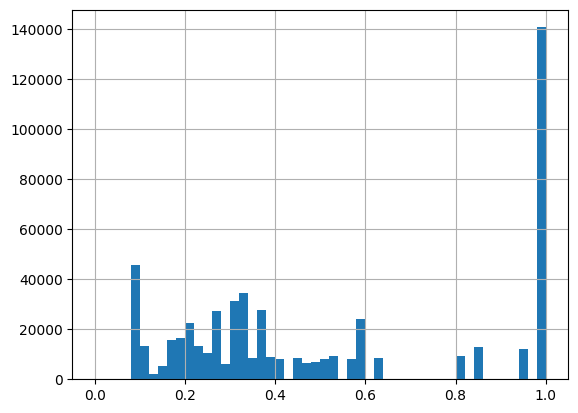

In [65]:
df_lgd["PD_12M_FINAL"].hist(bins=50)

In [66]:
df_lgd["ECL_12M"].describe()


count    553003.000000
mean          4.549838
std           4.963638
min           0.000000
25%           0.908885
50%           2.502619
75%           6.617938
max          51.261712
Name: ECL_12M, dtype: float64

<Axes: >

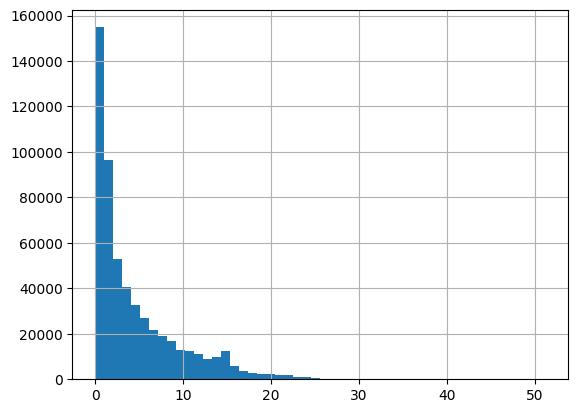

In [67]:
df_lgd["ECL_12M"].hist(bins=50)


In [68]:
df_lgd.groupby(CFG["state"])["ECL_12M"].sum().sort_values(ascending=False)


STATE_MODEL
DPD0        1.506169e+06
DPD90+      5.757746e+05
DPD1+       1.394454e+05
DPD30+      1.218027e+05
DPD60+      9.274824e+04
WRITEOFF    8.013478e+04
Name: ECL_12M, dtype: float64

In [69]:
df_lgd.groupby(CFG["mob"])["ECL_12M"].sum().sort_values(ascending=False)


MOB
0     321230.045564
1     273221.476170
2     252787.440920
3     231829.727322
4     179074.724870
9     164929.010582
10    159935.385917
5     149123.999724
6     148121.957091
7     140126.403087
11    107344.075757
8     104339.946403
12     96944.833128
13     63987.302756
14     42648.560727
15     28217.160050
16     17602.125160
17     10628.522277
18      6950.124695
19      5880.689355
21      4037.041921
20      3195.128411
22      2116.247166
23       973.578575
24       828.732215
Name: ECL_12M, dtype: float64

In [71]:
df_flag_high_risk = df_lgd[
    (df_lgd["PD_12M_FINAL"] > 0.5) |
    (df_lgd["LGD_EFF"] > 0.7) |
    (df_lgd["ECL_12M"] > 50_000_000)   # tuỳ chỉnh
]

df_check = df_flag_high_risk.sort_values("ECL_12M", ascending=False)


In [ ]:
df_check.to_excel("check_PD.xlsx", index=False)


In [74]:
df_check.to_csv("check_PD.csv")

In [75]:
calib_table


,SEG_PRODUCT,SEG_SCORE,TOTAL_EAD,REALIZED_PD_12M,PD_12M_MARKOV_AVG,K_FACTOR,NOTE
0,CDLPIL,500-,9.914267e+06,0.375193,0.382096,0.981933,"calibrated (k_raw=0.982, clipped=[0.25,3.0])"
1,CDLPIL,550-,1.112094e+07,0.257591,0.255058,1.009930,"calibrated (k_raw=1.010, clipped=[0.25,3.0])"
2,CDLPIL,600-,1.244621e+07,0.184442,0.174433,1.057381,"calibrated (k_raw=1.057, clipped=[0.25,3.0])"
3,CDLPIL,650+,1.203303e+07,0.066031,0.056935,1.159772,"calibrated (k_raw=1.160, clipped=[0.25,3.0])"
4,CDLPIL,650-,1.043796e+07,0.124179,0.112022,1.108514,"calibrated (k_raw=1.109, clipped=[0.25,3.0])"
5,CDLPIL,OTHERS,5.528072e+06,0.153307,0.154515,0.992186,"calibrated (k_raw=0.992, clipped=[0.25,3.0])"


## 

In [76]:
loan  = CFG["loan"]
state = CFG["state"]
mob   = CFG["mob"]
ead   = CFG["ead"]

df_current = df_ead_lastest_clean.copy()

df_current[mob] = df_current[mob].fillna(0).astype(int)
df_current[ead] = pd.to_numeric(df_current[ead], errors="coerce").fillna(0)
df_current[state] = df_current[state].astype(str)


In [49]:
df_pd = compute_forward_pd(
    df_current=df_current,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon=12
)

df_pd = df_pd.rename(columns={"PD_12M": "PD_12M_CALIB"})

df_current = df_current.merge(df_pd[[loan, "PD_12M_CALIB"]], on=loan, how="left")

# PD FINAL = PD calib (tạm chưa dùng macro)
df_current["PD_12M_FINAL"] = df_current["PD_12M_CALIB"]
df_current["PD_12M_FINAL"] = df_current["PD_12M_FINAL"].fillna(0)


KeyError: 'PD_12M_CALIB'

In [ ]:
df_current["MOB_AT_DEFAULT"] = (df_current[mob] + 6).astype(int)
df_current["MOB_AT_DEFAULT"] = df_current["MOB_AT_DEFAULT"].clip(lower=0)


In [ ]:
lgd_base["MOB_BUCKET_MIN"] = lgd_base["MOB_BUCKET"].str.split("-").str[0].astype(int)
lgd_base["MOB_BUCKET_MAX"] = lgd_base["MOB_BUCKET"].str.split("-").str[1].astype(int)


In [46]:
df_lgd = df_current.merge(
    lgd_base,
    left_on="PRODUCT_TYPE",
    right_on="PRODUCT_SEGMENT",
    how="left"
)


In [47]:
mask_bucket = (
    (df_lgd["MOB_AT_DEFAULT"] >= df_lgd["MOB_BUCKET_MIN"]) &
    (df_lgd["MOB_AT_DEFAULT"] <= df_lgd["MOB_BUCKET_MAX"])
)

df_lgd = df_lgd[mask_bucket].copy()


KeyError: 'MOB_AT_DEFAULT'

In [48]:
df_lgd["LGD_EFF"] = df_lgd["LGD_BASE"].fillna(df_lgd["LGD_BASE"].mean())
df_lgd["LGD_EFF"] = df_lgd["LGD_EFF"].fillna(0.5)   # fallback an toàn


In [83]:
df_lgd["ECL_12M"] = (
    df_lgd["PD_12M_FINAL"].fillna(0) *
    df_lgd["LGD_EFF"].fillna(0) *
    df_lgd[ead].fillna(0)
)


In [89]:
prod  = "CDLPIL"
score = "OTHERS-"  # ví dụ

for mob_val, obj in calib_matrices_by_mob[prod].items():
    is_fallback_any = any(sinfo["is_fallback"] for s, sinfo in obj.items())
    print(mob_val, "fallback:", is_fallback_any)


0 fallback: False
1 fallback: False
2 fallback: False
3 fallback: False
4 fallback: False
5 fallback: False
6 fallback: False
7 fallback: False
8 fallback: False
9 fallback: False
10 fallback: False
11 fallback: False
12 fallback: False
13 fallback: False
14 fallback: False
15 fallback: False
16 fallback: False
17 fallback: False
18 fallback: False
19 fallback: False
20 fallback: False
21 fallback: False
22 fallback: False
23 fallback: False


In [91]:
for mob in range(0,6):
    print(matrices_by_mob["CDLPIL"][mob]["550-"]["is_fallback"],
          matrices_by_mob["CDLPIL"][mob]["550-"]["reason"])


False 
False 
False 
False 
False 
False 


In [93]:
df[CFG["state"]].value_counts()


STATE_MODEL
DPD0        16714506
PREPAY      14508068
DPD90+       1769239
WRITEOFF      832061
DPD1+         665092
DPD30+        435881
DPD60+        335313
Name: count, dtype: int64

In [98]:
parent_P = parent_fallback[("CDLPIL", "550-")]
parent_P


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.941531,0.037807,0.000010,0.000002,0.000000,0.0,0.0,0.020651,0.000000,0.0
DPD1+,0.101312,0.209512,0.663057,0.007117,0.000000,0.0,0.0,0.019003,0.000000,0.0
DPD30+,0.012686,0.039442,0.155901,0.739892,0.027127,0.0,0.0,0.024867,0.000086,0.0
DPD60+,0.002169,0.002181,0.006689,0.074996,0.903495,0.0,0.0,0.009235,0.001235,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


In [96]:
loan  = CFG["loan"]
state = CFG["state"]
mob   = CFG["mob"]
ead   = CFG["ead"]

# Chỉ lấy performing DPD0 để soi, dễ nhìn nhất
df_dpd0 = df_lgd[df_lgd[state] == "DPD0"].copy()

pd_by_mob_dpd0 = (
    df_dpd0
    .groupby(mob)
    .apply(lambda g: (g["PD_12M_FINAL"] * g[ead]).sum() / g[ead].sum())
    .reset_index(name="PD_12M_FINAL_EAD_W")
    .sort_values(mob)
)

pd_by_mob_dpd0.head(15)


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_11660\1645968406.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["PD_12M_FINAL"] * g[ead]).sum() / g[ead].sum())


,MOB,PD_12M_FINAL_EAD_W
0,0,0.945545
1,1,1.054159
2,2,1.105750
3,3,1.124586
4,4,0.934862
5,5,0.765303
6,6,0.758375
7,7,0.703901
8,8,0.656487
9,9,0.662338


In [101]:
import pandas as pd

def show_PD_per_mob(matrices_by_mob, product, score, max_mob=12):
    rows = []
    for mob in range(0, max_mob+1):
        try:
            P = matrices_by_mob[product][mob][score]["P"]
        except:
            continue
        
        pd12 = P.loc["DPD0", "WRITEOFF"]
        row = {
            "MOB": mob,
            "PD_1M": pd12,
            "IsFallback": matrices_by_mob[product][mob][score]["is_fallback"],
            "Reason": matrices_by_mob[product][mob][score]["reason"],
        }
        rows.append(row)
    return pd.DataFrame(rows)

df_pd_mob = show_PD_per_mob(matrices_by_mob, "CDLPIL", "650-")
print(df_pd_mob)


    MOB  PD_1M  IsFallback Reason
0     0    0.0       False       
1     1    0.0       False       
2     2    0.0       False       
3     3    0.0       False       
4     4    0.0       False       
5     5    0.0       False       
6     6    0.0       False       
7     7    0.0       False       
8     8    0.0       False       
9     9    0.0       False       
10   10    0.0       False       
11   11    0.0       False       
12   12    0.0       False       


In [103]:
import numpy as np

def compute_PD_12M(matrices_by_mob, product, score, start_mob=0, horizon=12):
    P_chain = None
    
    for mob in range(start_mob, start_mob + horizon):
        P = matrices_by_mob[product][mob][score]["P"]
        if P_chain is None:
            P_chain = P.copy()
        else:
            P_chain = P_chain @ P  # nhân chuỗi 1-step
        
    # Vector bắt đầu luôn là DPD0 100%
    initial = np.zeros(len(P_chain.columns))
    initial[list(P_chain.index).index("DPD0")] = 1.0
    
    dist_12m = initial @ P_chain.values
    
    return pd.Series(dist_12m, index=P_chain.columns)


dist = compute_PD_12M(matrices_by_mob, "CDLPIL", "550-")
print("PD_12M =", dist["DPD90+"])


PD_12M = 0.20837828320535245


In [104]:
prod = "CDLPIL"
score = "500-"   # hoặc score bạn có

P0 = calib_matrices_by_mob[prod][0][score]["P"]
P0.loc["DPD0"]


state_t1
DPD0        0.954420
DPD1+       0.030655
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.014925
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64

In [106]:
prod = "CDLPIL"
score = "600-"      # đổi theo segment bạn muốn xem
max_mob_to_show = 24

for mob_i in range(0, max_mob_to_show + 1):
    try:
        P = calib_matrices_by_mob[prod][mob_i][score]["P"]
        row = P.loc["DPD0"]    # chỉ xem chuyển từ DPD0
        print(f"\n===== MOB {mob_i} – Transition from DPD0 =====")
        print(row)
    except KeyError:
        print(f"\n>>> Không có ma trận cho MOB {mob_i}")



===== MOB 0 – Transition from DPD0 =====
state_t1
DPD0        0.969003
DPD1+       0.013901
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.017096
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64

===== MOB 1 – Transition from DPD0 =====
state_t1
DPD0        0.970132
DPD1+       0.021173
DPD30+      0.000004
DPD60+      0.000000
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.008691
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64

===== MOB 2 – Transition from DPD0 =====
state_t1
DPD0        0.967507
DPD1+       0.023342
DPD30+      0.000037
DPD60+      0.000009
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.009105
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64

===== MOB 3 – Transition from DPD0 =====
state_t1
DPD0        0.956976
DPD1+       0.032807
DPD30+      0.000000
DPD60+      0.000000
D

In [108]:
parent_P = parent_fallback[("CDLPIL", "550-")]
print(parent_P.loc["DPD0"])


state_t1
DPD0        0.941531
DPD1+       0.037807
DPD30+      0.000010
DPD60+      0.000002
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.020651
WRITEOFF    0.000000
SOLDOUT     0.000000
Name: DPD0, dtype: float64


In [110]:
row = df_bt.sample(1).iloc[0]
prod, score, mob = row.PRODUCT_TYPE, row.RISK_SCORE, row.MOB
state = row.STATE
print(row)

pd_12 = calib_mod._compute_pd_markov_single(
    product=prod,
    score=score,
    mob=mob,
    state=state_mode,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    horizon=12,
)
print("PD_12M_single =", pd_12)


AttributeError: 'Series' object has no attribute 'STATE'

In [112]:
def debug_pd_path(product, score):
    for mob in range(0, 23):
        try:
            P = matrices_by_mob[product][mob][score]["P"]
            print(mob, float(P.loc["DPD0", "WRITEOFF"]))
        except:
            pass

debug_pd_path("CDLPIL", "550-")


0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0


In [115]:
matrices_by_mob["CDLPIL"][0]["550-"]["P"]



state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.962406,0.021488,0.000000,0.000000,0.000000,0.0,0.0,0.016106,0.000000,0.0
DPD1+,0.203917,0.234869,0.534024,0.000000,0.000000,0.0,0.0,0.027189,0.000000,0.0
DPD30+,0.012686,0.039442,0.155901,0.739892,0.027127,0.0,0.0,0.024867,0.000086,0.0
DPD60+,0.002169,0.002181,0.006689,0.074996,0.903495,0.0,0.0,0.009235,0.001235,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


In [116]:
parent_fallback["CDLPIL","550-"]

state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.941531,0.037807,0.000010,0.000002,0.000000,0.0,0.0,0.020651,0.000000,0.0
DPD1+,0.101312,0.209512,0.663057,0.007117,0.000000,0.0,0.0,0.019003,0.000000,0.0
DPD30+,0.012686,0.039442,0.155901,0.739892,0.027127,0.0,0.0,0.024867,0.000086,0.0
DPD60+,0.002169,0.002181,0.006689,0.074996,0.903495,0.0,0.0,0.009235,0.001235,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


In [117]:
row = df_lgd[
    (df_lgd[CFG["state"]] == "DPD0") &
    (df_lgd[CFG["mob"]] == 0)
].iloc[0]

row


CUTOFF_DATE              2025-10-01 00:00:00
AGREEMENT_ID                         6907215
DISBURSAL_DATE           2025-10-01 00:00:00
DISBURSAL_AMOUNT                       14.98
DPD_EOM                                    0
RISK_BUCKET                               B0
PRINCIPLE_OUTSTANDING              13.598216
STATUS                                     A
MOB                                        0
PRODUCT_TYPE                          CDLPIL
NPA_STAGEID                          REGULAR
DPD_GROUP                               DPD0
STATE_MODEL                             DPD0
RISK_SCORE                              500-
EAD_LATEST                         13.598216
PD_12M_CALIB                        1.717092
PD_12M_FINAL                        1.717092
MOB_AT_DEFAULT                             6
PRODUCT_SEGMENT                       CDLPIL
MOB_BUCKET                               0-6
LGD_BASE                            0.922378
MOB_BUCKET_MIN                             0
MOB_BUCKET

In [120]:
def debug_forward_for_row(row, matrices_by_mob, parent_fallback, horizon=12):
    state = CFG["state"]
    mob   = CFG["mob"]

    current_state = row[state]
    current_mob   = int(row[mob])
    product       = row.get("PRODUCT_TYPE", "ALL")
    score         = row.get("RISK_SCORE", "ALL")

    print(f"Debug loan={row[CFG['loan']]}, state={current_state}, mob={current_mob}, product={product}, score={score}")

    PD_12M, mPD, pi_path = compute_forward_pd_one_record(
        current_state=current_state,
        current_mob=current_mob,
        product=product,
        score=score,
        matrices_by_mob=matrices_by_mob,
        parent_fallback=parent_fallback,
        horizon=horizon,
        debug=True   # bạn thêm option debug vào hàm để in ra P dùng mỗi bước
    )

    print("PD_12M =", PD_12M)
    return PD_12M, mPD, pi_path


In [121]:
PD_12M, mPD, pi_path = debug_forward_for_row(row, calib_matrices_by_mob, calib_parent_fallback, horizon=12)


Debug loan=6907215, state=DPD0, mob=0, product=CDLPIL, score=500-


TypeError: compute_forward_pd_one_record() got an unexpected keyword argument 'debug'

In [123]:
import importlib
import src.rollrate.pd_forward as pd_fwd

importlib.reload(pd_fwd)


<module 'src.rollrate.pd_forward' from 'C:\\Users\\MAFC4709\\Python_work\\RR_model_ECL\\src\\rollrate\\pd_forward.py'>

In [124]:
from src.rollrate.pd_forward import compute_forward_pd_one_record


In [125]:
row = df_lgd[
    (df_lgd[CFG["state"]]=="DPD0") &
    (df_lgd[CFG["mob"]]==0)
].iloc[0]

PD12, mPD, pi_path = compute_forward_pd_one_record(
    current_state=row[CFG["state"]],
    current_mob=int(row[CFG["mob"]]),
    product=row["PRODUCT_TYPE"],
    score=row["RISK_SCORE"],
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon=12,
    debug=True
)



=== Month t=1, mob_key=0 ===
Current π:
DPD0        1.0
DPD1+       0.0
DPD30+      0.0
DPD60+      0.0
DPD90+      0.0
DPD120+     0.0
DPD180+     0.0
PREPAY      0.0
WRITEOFF    0.0
SOLDOUT     0.0
dtype: float64
Using transition matrix P:
state_t
DPD0      0.000000
DPD1+     0.000000
DPD30+    0.029077
DPD60+    0.888431
DPD90+    1.000000
Name: DPD90+, dtype: float64

=== Month t=2, mob_key=1 ===
Current π:
state_t1
DPD0        0.954420
DPD1+       0.030655
DPD30+      0.000000
DPD60+      0.000000
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.000000
PREPAY      0.014925
WRITEOFF    0.000000
SOLDOUT     0.000000
dtype: float64
Using transition matrix P:
state_t
DPD0      0.000000
DPD1+     0.000000
DPD30+    0.000000
DPD60+    0.888431
DPD90+    1.000000
Name: DPD90+, dtype: float64

=== Month t=3, mob_key=2 ===
Current π:
state_t1
DPD0        0.903319
DPD1+       0.051896
DPD30+      0.021179
DPD60+      0.000105
DPD90+      0.000000
DPD120+     0.000000
DPD180+     0.0

In [126]:
import importlib
import src.rollrate.pd_forward as pd_fwd

importlib.reload(pd_fwd)
from src.rollrate.pd_forward import compute_forward_pd_one_record, compute_forward_pd


In [ ]:
df_pd = compute_forward_pd(
    df_current=df_current,
    matrices_by_mob=calib_matrices_by_mob,
    parent_fallback=calib_parent_fallback,
    horizon=12,
)

df_pd["PD_12M"].describe()


In [ ]:
df_dpd0 = df_lgd[df_lgd[CFG["state"]] == "DPD0"].copy()

pd_by_mob_dpd0 = (
    df_dpd0
    .groupby(CFG["mob"])
    .apply(lambda g: (g["PD_12M_FINAL"] * g[CFG["ead"]]).sum() / g[CFG["ead"]].sum())
    .reset_index(name="PD_12M_FINAL_EAD_W")
    .sort_values(CFG["mob"])
)

pd_by_mob_dpd0.head(20)
